# **Proximal Policy Optimization Algorithm in discrete action space**
**Testing Environment: [MountainCar](https://gym.openai.com/envs/MountainCar-v0/)**

**Coding Framework: Python3, PyTorch**

**Best Reward -96.200 in 420 epochs (mean on 10 tests each 10 epochs):**
**[video](https://drive.google.com/open?id=10cpTy4QWqpacS9IYbivK2g7G_GGsIAA9)** **,** **[plot](https://drive.google.com/open?id=1-_dgAEz_cCsBUQKMWaDWKwZeCZNz6I7j)** **and** **[trained model](https://drive.google.com/open?id=1WZTRdjt43oqcyaAJXm-zlDUKQprkVpTP)**

*Simone Rossetti*

**1. Install required libraries**

In [0]:
!pip install gym # environmnet
!pip install torch # framework
!apt-get install x11-utils # visualization
!pip install stable-baselines # multiple environment
!apt-get install -y xvfb python-opengl > /dev/null 2>&1 # visualization
!pip install gym pyvirtualdisplay > /dev/null 2>&1 # visualization

**2. Dependencies**

In [0]:
import os
import gym
import torch
import base64
import imageio
import numpy as np
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython.display import clear_output
from torch.distributions import Categorical
from IPython import display as ipythondisplay
from stable_baselines.common.vec_env import VecVideoRecorder, SubprocVecEnv

**3. Locate Google Drive directory to save models and progress**

In [0]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

**4. Initialize global variables and hyperparameters**

Some hyperparameters have been chosen according to PPO research paper (`E_CLIP`, `G_GAE`, `L_GAE`, `E_CLIP`, `C_2`), others according to some empirical tests. 

For instance, `L_RATE = 1e-3` with `ReLU` returns very bad performances, too slow and inconsistent training; `L_RATE = 1e-1` with `ReLU` gets stuck in single classification.

`C_1`  is lower compared to the one on the official PPO paper (`C_1 = 1`) because otherwise the classifier stucks in a single classification. 

`T`, `N`, `M` have been chosen according to minibatch size *M <= N T*.

`K` has been chosen to reach a good compromise between gradient updates and time requirements.


In [0]:
ENV_ID = "MountainCar-v0"
H_SIZE = 256 # hidden size, linear units of the output layer
L_RATE = 1e-2 # learning rate, gradient coefficient for network's weight update
G_GAE = 0.99 # gamma param for GAE
L_GAE = 0.95 # lambda param for GAE
E_CLIP = 0.2 # clipping coefficient
C_1 = 0.5 # squared loss coefficient
C_2 = 0.01 # entropy coefficient
N = 8 # simultaneous processing environments
T = 256 # PPO steps 
M = 64 # mini batch size
K = 10 # PPO epochs
T_EPOCHS = 10 # each T_EPOCH 
N_TESTS = 10 # do N_TESTS tests 
TARGET_REWARD = -100
TRANSFER_LEARNING = True
PATH='/content/drive/My Drive/PPO_MOUNTAINCAR/checkpoints/MountainCar-v0_-96.200_420.dat'

**5. Define Linear model for discrete action space**

This simple network is made by two dense layer activated by non linear activation function `ReLU`. The first network, the critic, evaluate the state. The second network, the actor, estimate the most probable action to pick in different states.

In [0]:
class LinearModel(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(LinearModel, self).__init__()
        self.critic = nn.Sequential( # The “Critic” estimates the value function
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.actor = nn.Sequential( # The “Actor” updates the policy distribution in the direction suggested by the Critic (such as with policy gradients)
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist = Categorical(probs)
        return dist, value


**6. Define auxiliary functions**

In [0]:
display = Display(visible=0, size=(400, 300))
display.start() # initialize display to play last test environment

for func in [
             lambda:os.mkdir(os.path.join('.', 'PPO_MOUNTAINCAR')),
             lambda: os.mkdir(os.path.join('.', 'PPO_MOUNTAINCAR/checkpoints')),
             lambda: os.mkdir(os.path.join('.', 'PPO_MOUNTAINCAR/records')),
             lambda: os.mkdir(os.path.join('.', 'PPO_MOUNTAINCAR/plots'))
             ]: # create directories
   try:
       func()
   except Exception as error: 
       print (error)
       continue

def make_env():
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _thunk():
        env = gym.make(ENV_ID).env
        return env
    return _thunk

def normalize(x):
    x -= x.mean()
    x /= (x.std() + 1e-8)
    return x

def test_env(env, model, device):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
    return total_reward

def plot(train_epoch, rewards, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('%s: Epoch: %s -> Reward: %s' % (ENV_ID, train_epoch, test_rewards[-1]))
    fig = plt.ylabel('Reward')
    fig = plt.xlabel('Epoch')
    fig = plt.plot(test_rewards)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    if save:
        get_fig.savefig('PPO_MOUNTAINCAR/plots/%s_%d.png' % (ENV_ID, test_rewards[-1]))

def record_video(env_id, model, video_length=500, prefix='', video_folder='PPO_MOUNTAINCAR/records/'):
  eval_env = SubprocVecEnv([lambda: gym.make(env_id)])
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  state = eval_env.reset() 
  for _ in range(video_length):
    state = torch.FloatTensor(state).to(device)
    dist, _ = model(state)
    action = dist.sample().cpu().numpy() if use_cuda else dist.sample().numpy()
    next_state, _, _, _ = eval_env.step(action)
    state = next_state
  eval_env.close()

def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

**7. Generalized Advantage Estimation**

For each result collected with respect to each action by the algorithm, it computes the delta, which is the sum of current reward and the expected success of the next state (next state value minus current state value), zero if 'done' is reached.
So it computes the sum over all collected states, until last is reached.

GAE is computed summing all GAE of previous actions. It is higher if near actions had success, lower otherwhise.

At the end it sums again the value of current state, so that actions in different states obtain bonus or malus if a better states are reached thanks to those actions.

In [0]:
def compute_gae(next_value, rewards, masks, values, gamma=G_GAE, lam=L_GAE):
    values = values + [next_value] # concat last value to the list
    gae = 0 # first gae always to 0
    returns = []
    
    for step in reversed(range(len(rewards))): # for each positions with respect to the result of the action 
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step] 
        gae = delta + gamma * lam * masks[step] * gae 
        returns.insert(0, gae + values[step]) 
    return returns


**8. Mini batch generator**

This is an iterative random generator of mini-batch of M samples, it generates and returns mini-batches until it covers the full batch.

In [0]:
def ppo_iter(states, actions, log_probs, returns, advantage):     # generates random mini-batches until we have covered the full batch

    batch_size = states.size(0)

    for _ in range(batch_size // M):
      
        rand_ids = np.random.randint(0, batch_size, M)  # integer array
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

 **9. PPO Algorithm: Critic**

For `K` times analyze all the collected data to make gradient updates.

At first, the algorithm grabs random mini-batches several times until it covers all data. 
It takes a state in the batch, from the policy it computes how good is stay in it, then it takes the action that generated that state and computes the new log probability for the action with respect to the current policy (updates during *P* iterations, so, first iteration for new action non visited will be 1).

Now, it computes the ratio (`new_prob/old_prob`) of changing of the probability of the action for that state (depending on the training of the policy).

The algorithm computes the first surrogate function, which promotes the action that increased the advantage, due to its probability variation.

After that, it repeats the same computation as before but cutting the ratio values out of a certain range to avoid hysteresis, this is called *CLIP*, and is made to penalize changes to the policy that move the ratio away from 1. It only ignores the change in probability ratio when it would make the objective improve, and it includes the ratio when ratio makes the objective worse.

At this point, the algorithm takes the minimum of the two surrogate and do the mean, it computes the 'surrogate loss' in which includes only actions that decrease the performances of the actor. 
It also computes a squared loss for the actor, that is the squared loss of the reward of the action in the state with respect to the policy estimation of the action in the state.

Now, the algorithm can compute the loss function, adding the clipped actor loss and the squared critic loss, summing also some entropy bonus, to guarantee the model to promote exploration beyond exploitation.

At the end of each step, the algorithm updates the weights of the model thanks to the gradient, generated by Adam algorithm.


In [0]:
def ppo_update(states, actions, log_probs, returns, advantages, clip_param=E_CLIP):

    for _ in range(K):

        for state, action, old_log_probs, return_, advantage in ppo_iter(states, actions, log_probs, returns, advantages):
            
            dist, value = model(state)
            entropy = dist.entropy().mean()
            action = action.reshape(1, len(action)) # take the relative action and take the column
            new_log_probs = dist.log_prob(action)
            new_log_probs = new_log_probs.reshape(len(old_log_probs), 1) # take the column
            ratio = (new_log_probs - old_log_probs).exp() # new_prob/old_prob
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage 
            actor_loss = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()
            loss = C_1 * critic_loss + actor_loss - C_2 * entropy
            optimizer.zero_grad() # in PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. This is convenient while training RNNs. So, the default action is to accumulate (i.e. sum) the gradients on every loss.backward() call.
            loss.backward() # computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x. In pseudo-code:
            optimizer.step() # optimizer.step performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule.


**10. PPO Algorithm: Actor**

For `T` steps generate random actions and collect effects in the environment.

In the very first moment, consider the current state of the environment and thanks to the current policy evaluates the state, it associate to each action the probability to be best suited to that state.
The agent picks from the policy an action with some probability. Then the agent execute that action in the environment, the action modifies the state in the environment and new percepts are collected (data of value function, rewards and probabilities for each actions). Plus, add to collection a vector *masks* that keeps track of the end state of the environment (if the environment has reached `done` state).

At then end of this first empirical step,the algorithm computes the generalized advantage estimation to estimate for each action if it improves the value function for the next state (if the action has taken the agent in a better state).

Now that all necessary data are collected, the second step of the algorithm analyze and update the weights of the model thanks to the Adam algorithm.

At the end of the computation the epoch ends.


In [0]:
def ppo_train(model, envs, device, use_cuda, test_rewards, test_epochs, train_epoch, best_reward, early_stop = False):
    env = gym.make(ENV_ID).env
    state = envs.reset()

    while not early_stop:
        log_probs = []
        values = []
        states = []
        actions = []
        rewards = []
        masks = []

        for _ in range(T):         # for 256 time steps generate random moves in 8 environment and collect data

            state = torch.FloatTensor(state).to(device)
            dist, value = model(state)  # nn evaluate the state
            action= dist.sample().cuda() if use_cuda else dist.sample()
            next_state, reward, done, _ = envs.step(action.cpu().numpy())
            log_prob = dist.log_prob(action) 
            log_prob_vect = log_prob.reshape(len(log_prob), 1)
            log_probs.append(log_prob_vect) # needed to compute probability ratio r(theta) that prevent policy to vary too much probability related to each action (make the computations more robust) 
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device)) # all 1 vector, when goal is reached then is 0
            states.append(state)
            action_vect = action.reshape(len(action), 1)
            actions.append(action_vect)
            state = next_state

        next_state = torch.FloatTensor(next_state).to(device) # consider last state of the collection step
        _, next_value = model(next_state) # collect last value effect of the last collection step
        returns = compute_gae(next_value, rewards, masks, values)
        returns = torch.cat(returns).detach() # concatenates along existing dimension and detach the tensor from the network graph, making the tensor no gradient
        log_probs = torch.cat(log_probs).detach() 
        values = torch.cat(values).detach()
        states = torch.cat(states)
        actions = torch.cat(actions)
        advantage = returns - values # compute advantage for each action
        advantage = normalize(advantage) # compute the normalization of the vector to make uniform values
        ppo_update(states, actions, log_probs, returns, advantage)
        train_epoch += 1

        if train_epoch % T_EPOCHS == 0: # do a test every T_EPOCHS times

            test_reward = np.mean([test_env(env, model, device) for _ in range(N_TESTS)]) # do N_TESTS tests and takes the mean reward
            test_rewards.append(test_reward) # collect the mean rewards for saving performance metric
            test_epochs.append(train_epoch)
            print('Epoch: %s -> Reward: %s' % (train_epoch, test_reward))

            if best_reward is None or best_reward < test_reward: # save a checkpoint every time it achieves a better reward
                if best_reward is not None:
                    print("Best reward updated: %.3f -> %.3f" %
                          (best_reward, test_reward))
                    name = "%s_%+.3f_%d.dat" % (ENV_ID, test_reward, train_epoch)
                    fname = os.path.join('.', 'PPO_MOUNTAINCAR/checkpoints', name)
                    states = {
                      'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(),
                      'test_rewards': test_rewards,
                      'test_epochs': test_epochs,
                    }
                    torch.save(states, fname) # save the model, for transfer learning is important to save: model parameters, optimizer parameters, epochs and rewards record as well
                
                best_reward = test_reward
                
            if test_reward > TARGET_REWARD: # stop training if archive the best
                early_stop = True

**11. Implementation of PPO Algorithm: Actor-Critic Style**

Main function, for `N` agents (in `N` environments) join parallel *PPO* training.

The policy model is a Neural Network with two *256* hidden size dense layers. It implements *Adam* algorithm.

It is possible to set transfer learning by setting the `PATH` to the model and `TRANSFER_LEARNING` to `True` in section **4**. 

`test_rewards` is a list that record previous checkpoints rewards. `train_epoch` record the epoch needed to train the model at the current state.



In [0]:
if __name__ == "__main__":

    use_cuda = torch.cuda.is_available() # Autodetect CUDA
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Device:', device)
    
    envs = [make_env() for i in range(N)] # Prepare environments
    envs = SubprocVecEnv(envs)  # Vectorized Environments are a method for stacking multiple independent environments into a single environment. Instead of training an RL agent on 1 environment per step, it allows us to train it on n environments per step. Because of this, actions passed to the environment are now a vector (of dimension n). It is the same for observations, rewards and end of episode signals (dones). In the case of non-array observation spaces such as Dict or Tuple, where different sub-spaces may have different shapes, the sub-observations are vectors (of dimension n).
    num_inputs = envs.observation_space.shape[0]
    num_outputs = envs.action_space.n
    model = LinearModel(num_inputs, num_outputs, H_SIZE).to(device) # save the model, Tensor.to(device) Moves and/or casts the parameters and buffers.
    optimizer = optim.Adam(model.parameters(), lr=L_RATE) # Implements Adam algorithm.
    test_rewards = []
    test_epochs = [] 
    train_epoch = 0
    best_reward = None

    if TRANSFER_LEARNING: # transfer learning set this variable to True
      if use_cuda:
        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        test_rewards=checkpoint['test_rewards']
        test_epochs=checkpoint['test_epochs']
        train_epoch=test_epochs[-1]
        best_reward=test_rewards[-1]
      else:
        checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        test_rewards=checkpoint['test_rewards']
        test_epochs=checkpoint['test_epochs']
        train_epoch=test_epochs[-1]
        best_reward=test_rewards[-1]
      print('CNN: loaded')
      print('Previous best reward: %.3f'%(best_reward))
      model.train()

    print(model)
    print(optimizer)
      
    ppo_train(model, envs, device, use_cuda, test_rewards, test_epochs, train_epoch, best_reward)

Device: cpu
CNN: loaded
Previous best reward: -96.200
LinearModel(
  (critic): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=3, bias=True)
    (3): Softmax(dim=1)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


**12. Print rewards history**

In [0]:
for epoch, reward in zip(test_epochs,test_rewards):
  print('Epoch: %s -> Reward: %s' % (epoch, reward))

Epoch: 10 -> Reward: -4507.7
Epoch: 20 -> Reward: -434.4
Epoch: 30 -> Reward: -168.7
Epoch: 40 -> Reward: -147.5
Epoch: 50 -> Reward: -142.8
Epoch: 60 -> Reward: -124.4
Epoch: 70 -> Reward: -135.4
Epoch: 80 -> Reward: -125.0
Epoch: 90 -> Reward: -123.3
Epoch: 100 -> Reward: -125.2
Epoch: 110 -> Reward: -120.2
Epoch: 120 -> Reward: -120.0
Epoch: 130 -> Reward: -124.8
Epoch: 140 -> Reward: -109.1
Epoch: 150 -> Reward: -135.4
Epoch: 160 -> Reward: -127.4
Epoch: 170 -> Reward: -127.2
Epoch: 180 -> Reward: -119.4
Epoch: 190 -> Reward: -115.2
Epoch: 200 -> Reward: -115.4
Epoch: 210 -> Reward: -125.2
Epoch: 220 -> Reward: -110.2
Epoch: 230 -> Reward: -110.5
Epoch: 240 -> Reward: -108.3
Epoch: 250 -> Reward: -110.4
Epoch: 260 -> Reward: -120.9
Epoch: 270 -> Reward: -121.1
Epoch: 280 -> Reward: -112.7
Epoch: 290 -> Reward: -115.9
Epoch: 300 -> Reward: -108.1
Epoch: 310 -> Reward: -112.4
Epoch: 320 -> Reward: -127.5
Epoch: 330 -> Reward: -121.2
Epoch: 340 -> Reward: -109.9
Epoch: 350 -> Reward: 

**13. Plot learning progress**

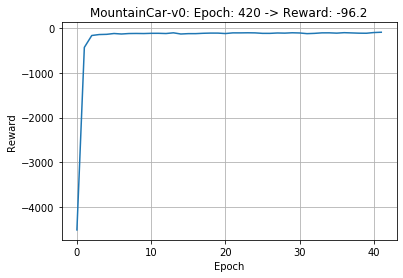

In [0]:
plot(train_epoch, test_rewards, save=True)

**14. Show model in environment**

In [0]:
record_video(ENV_ID, model, video_length=1000, prefix='ppo_mountaincar')
show_videos('PPO_MOUNTAINCAR/records/', prefix='ppo_mountaincar')